In [ ]:
import os
import random
from dataclasses import dataclass
import pickle
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset, DatasetDict, Dataset
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

import matplotlib.pyplot as plt

In [2]:
shuffle = 42

In [3]:
dataset_train = load_dataset("pandas", data_files="saved_pars/transformer_dataset_train.pkl")['train']
dataset_validation = load_dataset("pandas", data_files="saved_pars/transformer_dataset_validation.pkl")['train']
dataset_test = load_dataset("pandas", data_files="saved_pars/transformer_dataset_test.pkl")['train']


Found cached dataset pandas (/users/felix.wagner/.cache/huggingface/datasets/pandas/default-c46fa57facf0c0a8/0.0.0/3ac4ffc4563c796122ef66899b9485a3f1a977553e2d2a8a318c72b8cc6f2202)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset pandas (/users/felix.wagner/.cache/huggingface/datasets/pandas/default-b8ae2cee5f5334cb/0.0.0/3ac4ffc4563c796122ef66899b9485a3f1a977553e2d2a8a318c72b8cc6f2202)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset pandas (/users/felix.wagner/.cache/huggingface/datasets/pandas/default-03cc66ec0e07b29e/0.0.0/3ac4ffc4563c796122ef66899b9485a3f1a977553e2d2a8a318c72b8cc6f2202)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
dataset_train = dataset_train.shuffle(42)
dataset_validation = dataset_validation.shuffle(42)
dataset_test = dataset_test.shuffle(42)

Loading cached shuffled indices for dataset at /users/felix.wagner/.cache/huggingface/datasets/pandas/default-c46fa57facf0c0a8/0.0.0/3ac4ffc4563c796122ef66899b9485a3f1a977553e2d2a8a318c72b8cc6f2202/cache-8e4dad88354124b7.arrow
Loading cached shuffled indices for dataset at /users/felix.wagner/.cache/huggingface/datasets/pandas/default-b8ae2cee5f5334cb/0.0.0/3ac4ffc4563c796122ef66899b9485a3f1a977553e2d2a8a318c72b8cc6f2202/cache-353a862696a81e70.arrow
Loading cached shuffled indices for dataset at /users/felix.wagner/.cache/huggingface/datasets/pandas/default-03cc66ec0e07b29e/0.0.0/3ac4ffc4563c796122ef66899b9485a3f1a977553e2d2a8a318c72b8cc6f2202/cache-d8c5bebe3a48367f.arrow


In [5]:
@dataclass
class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 60 #subsets of the episode we use for training
    state_dim: int = 6  # size of state space
    act_dim: int = 2  # size of action space
    max_ep_len: int = 60 # max episode length in the dataset
    scale: float = 10.0  # normalization of rewards/returns
    target: float = 0.  # highest return in training set
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:
        self.act_dim = len(dataset[0]["actions"][0])
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        # calculate dataset stats for normalization of states
        states = []
        rewards = []
        traj_lens = []
        for obs, rew in zip(dataset["observations"], dataset["rewards"]):
            states.extend(obs)
            rewards.append(rew)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        rewards = np.array(rewards)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
        
        self.scale, self.target = np.abs(np.mean(np.sum(rewards, axis=1))), np.max(np.sum(rewards, axis=1))
        # this assumes all rewards have same sign
        
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(
            np.arange(self.n_traj),
            size=batch_size,
            replace=True,
            p=self.p_sample,  # reweights so we sample according to timesteps
        )
        # a batch of dataset features
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            # for feature in features:
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature["rewards"]) - 1)

            # get sequences from dataset
            s.append(np.array(feature["observations"][si : si + self.max_len]).reshape(1, -1, self.state_dim))
            a.append(np.array(feature["actions"][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature["rewards"][si : si + self.max_len]).reshape(1, -1, 1))

            d.append(np.array(feature["dones"][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature["rewards"][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state + reward normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        return {
            "states": s,
            "actions": a,
            "rewards": r,

            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
            
        }

In [6]:
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        
        loss = torch.mean((action_preds - action_targets) ** 2)

        return {"loss": loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

In [7]:
collator = DecisionTransformerGymDataCollator(dataset_train)

In [8]:
config = DecisionTransformerConfig(state_dim=collator.state_dim, 
                                   act_dim=collator.act_dim, 
                                   hidden_size=512,  # default 128, 10M 512, 40M 768, 200M 1280
                                   n_layer=4,  # default 3, 10M 4, 40M 6, 200M 10
                                   n_head=8,  # default 1, 10M 8, 40M 12, 200M 20
                                  )

In [9]:
# model = TrainableDT(config)

In [10]:
# model = TrainableDT.from_pretrained('/scratch-cbe/users/felix.wagner/rltests/output_40m/run1_checkpoint-56500')  # 40 M

model = TrainableDT.from_pretrained('/scratch-cbe/users/felix.wagner/rltests/output/checkpoint-90000')  # 10 M

# model = TrainableDT.from_pretrained('output/run1_checkpoint-47500/')  # 1 M

In [11]:
training_args = TrainingArguments(  # defaults from multiagent DT paper 
    output_dir="/scratch-cbe/users/felix.wagner/rltests/output/",
    remove_unused_columns=False,
    num_train_epochs=3000,
    per_device_train_batch_size=256,  # 64
    learning_rate=3e-4,  # 1e-4
    weight_decay=0.,  # 1e-4
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=1.,  # 0.25
    evaluation_strategy="steps",
    eval_steps=500,
    logging_steps=500,
    label_names=["actions"],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    data_collator=collator,
    eval_dataset=dataset_validation,
)

In [12]:
preds_test = trainer.predict(dataset_test)
preds_val = trainer.predict(dataset_validation)
print(preds_test.metrics)
print(preds_val.metrics)

# for wrong dataset loss was ~ 0.004 (50k steps)

# for correct data set (50k steps)

# test 0.10790583491325378
# validation 0.10896196961402893

# for correct data set 10M model (47.5k steps)

# test 0.05410
# validation 0.05418

# for correct data set 10M model (178.5k steps)

# test 0.01736
# validation 0.01809



{'test_loss': 0.0009194285375997424, 'test_runtime': 7.4022, 'test_samples_per_second': 340.438, 'test_steps_per_second': 42.555}
{'test_loss': 0.0009071200620383024, 'test_runtime': 7.1806, 'test_samples_per_second': 350.944, 'test_steps_per_second': 43.868}


In [ ]:
trainer.train('/scratch-cbe/users/felix.wagner/rltests/output/checkpoint-90000')

  0%|          | 0/20 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss
82000,0.001600,0.000985
82500,0.001600,0.001059
83000,0.001600,0.000972


# Inference

In [12]:
# Function that gets an action from the model using autoregressive prediction with a window of the previous 20 timesteps.
def get_action(model, states, actions, rewards, returns_to_go, timesteps):
    # This implementation does not condition on past rewards

    states = states.reshape(1, -1, model.config.state_dim)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    states = states[:, -model.config.max_length :]
    actions = actions[:, -model.config.max_length :]
    returns_to_go = returns_to_go[:, -model.config.max_length :]
    timesteps = timesteps[:, -model.config.max_length :]
    padding = model.config.max_length - states.shape[1]
    # pad all tokens to sequence length
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)
    states = torch.cat([torch.zeros((1, padding, model.config.state_dim)), states], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, model.config.act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )

    return action_preds[0, -1]

In [13]:
# thats crucial!

model.config.max_length = 60

In [104]:
# build the environment

name_load = 'li2p'
version = '24'
rseed = int(version)
buffer_save_path = 'buffers_inf/'
buffer_size = 5200

In [105]:
with open("saved_pars/{}_pars_cryoenv.pkl".format(name_load),"rb") as fh:
    pars_load = pickle.load(fh)

In [106]:
from cryoenv.mqtt import augment_pars
import gymnasium as gym
from tqdm.auto import trange

In [107]:
tries = 0

while True:
    
    if tries > 10:
        raise AssertionError

    add_pars = {
        'store_raw': True,
        'max_buffer_len': buffer_size,
        'tpa_queue': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'pileup_prob': 0.,
        'tp_interval': 10,
        'dac_range': (0., 5.) if name_load in ['li1p', 'li2p'] else (0., 10.),  # this was changed
        'Ib_range': (0.5, 5.) if name_load in ['li1p', 'li2p'] else (0.1, 3.),  # this was changed
        'adc_range': (-10., 10.),
        'rseed': rseed,
        'tau_cap': np.array([1.]),
                }

    np.random.seed(rseed)

    # pars_load = double_tes(pars_load)

    aug_pars = augment_pars(pars_load, **add_pars)
    # aug_pars = {**pars_load, **add_pars}

    env = gym.make('cryoenv:cryoenv-sig-v0',
                       omega=0.,
                       log_reward=False,
                       rand_start=True,
                       relax_time=60,
                       tpa_in_state=True,
                       div_adc_by_bias=True,
                       pars=aug_pars,
                       render_mode='plotly',
                       rand_tpa=False,
                       )

    # check if transition is reachable

    env.detector.set_control(dac=np.ones(env.nheater), Ib=np.ones(env.ntes), norm=True)

    for i in range(10):
        env.detector.wait(5)

    try:
        for i in range(env.ntes):  # assumes TES are the first components!
            assert env.detector.Rt[i](env.detector.T[0,i]) > env.detector.Rs[i], 'transition of TES {} not reachable'.format(i)
        print('All transistions reachable, continuing')
        break
    except AssertionError:
        rseed *= 1000
        tries += 1
        print('Resampling parameters, new rseed: {}'.format(rseed))

All transistions reachable, continuing


In [108]:
env.launch_display(title='Inference {} with {} TES'.format(name_load, env.ntes), 
                   color='red' if name_load == 'li1p' else 'turquoise' if name_load == 'li1l' else 'yellow' if name_load == 'li2p' else None)

FigureWidget({
    'data': [{'marker': {'color': 'yellow'},
              'mode': 'lines',
              'name…

In [127]:
model = model.to("cpu")
device = "cpu"

scale = collator.scale # 1000.0  # normalization for rewards/returns
TARGET_EXPLORE = -0.3
TARGET_EXPLOIT = -0.024 if name_load == 'li1p' else -0.08 if name_load == 'li1p' else -0.02 
TARGET_RETURN = TARGET_EXPLORE * 60 / scale  # collator.target # / scale  # 12000 / scale  # evaluation is conditioned on a return of 12000, scaled accordingly
print(scale, TARGET_RETURN)

state_mean = collator.state_mean.astype(np.float32)
state_std = collator.state_std.astype(np.float32)
print(state_mean)

state_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

state_mean = torch.from_numpy(state_mean).to(device=device)
state_std = torch.from_numpy(state_std).to(device=device)

6.28086632379302 -2.865846695672037
[-0.99449515 -0.9999367  -0.0147091  -0.12026685 -0.07332222 -0.98970175]


In [128]:
tries = 10

for try_ in range(tries):
    
    print('TRY {}/{}'.format(try_, tries))

    episode_return, episode_length = 0, 0

    state, _ = env.reset(clear_buffer=True)

    target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
    states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)

    switched = False

    timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
    for t in trange(60):
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        rewards = torch.cat([rewards, torch.zeros(1, device=device)])

        action = get_action(
            model,
            (states - state_mean) / state_std,
            actions,
            rewards,
            target_return,
            timesteps,
        )
        actions[-1] = action
        action = action.detach().cpu().numpy()

        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated


        cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        rewards[-1] = reward

        pred_return = target_return[0, -1] - (reward / scale)
        target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)


        episode_return += reward
        episode_length += 1

        if reward > -0.15 and not switched:
            target_return += (TARGET_EXPLOIT * 60 / scale - TARGET_RETURN) * (60-t)/60
            print('Switching in t={}'.format(t))
            switched = True

        if target_return[0,-1] > (60-t)*TARGET_EXPLORE/scale/2 and not switched:
            target_return[0, :] += (60-t)*(TARGET_EXPLORE/scale) - target_return[0, -1]
        if target_return[0,-1] > (60-t)*TARGET_EXPLOIT/scale/2  and switched:
            target_return[0, :] += (60-t)*(TARGET_EXPLORE/scale) - target_return[0, -1]
            switched = False
            print('Switching back in t={}'.format(t))

        timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

        if done:
            break
        
    if np.mean(-np.array(env.detector.buffer_rms[-30:])/np.array(env.detector.buffer_ph[-30:])) > 2 * TARGET_EXPLOIT:
        print('SUCCESS')
        break
        
    if try_ == tries - 1:
        print('FAILED')

TRY 0/10


  0%|          | 0/60 [00:00<?, ?it/s]

TRY 1/10


  0%|          | 0/60 [00:00<?, ?it/s]

Switching in t=10


/users/felix.wagner/cryoenv/cryoenv/cryosig/_detector_model.py:1199: RuntimeWarning:

overflow encountered in double_scalars

/users/felix.wagner/cryoenv/cryoenv/cryosig/_detector_model.py:1199: RuntimeWarning:

invalid value encountered in double_scalars

/users/felix.wagner/.local/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning:

Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.



TRY 2/10


/users/felix.wagner/cryoenv/cryoenv/cryosig/_detector_model.py:320: RuntimeWarning:

overflow encountered in multiply



  0%|          | 0/60 [00:00<?, ?it/s]

TRY 3/10


  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
np.mean(-np.array(env.detector.buffer_rms[-30:])/np.array(env.detector.buffer_ph[-30:]))

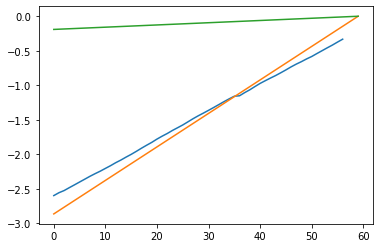

In [126]:
plt.plot(target_return.flatten())
plt.plot(np.linspace(TARGET_EXPLORE * 60 / scale,0,60))
plt.plot(np.linspace(TARGET_EXPLOIT * 60 / scale,0,60))